In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13.4 s, sys: 4.19 s, total: 17.6 s
Wall time: 11.1 s


In [2]:
%%time
# Dask gateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,4))
dc = datacube.Datacube()

client

An existing cluster was found. Connecting to: easihub.552b2503bd40489f85c6b881a5862074
CPU times: user 756 ms, sys: 21.7 ms, total: 778 ms
Wall time: 999 ms


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.552b2503bd40489f85c6b881a5862074/status,


In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.86575, 105.94120)
latitude_range = (9.65070, 9.69850)

In [ ]:
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)

In [ ]:
dsvv = calculate_average(dsvv, time_pattern='1M') 
dsvh = calculate_average(dsvh, time_pattern='1M') 

In [ ]:
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

In [ ]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

In [ ]:
# calculate NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

In [ ]:
%%time
## tính ndvi theo tháng
average_ndvi = calculate_average(ndvi,time_pattern="1M")
progress(average_ndvi)

In [ ]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

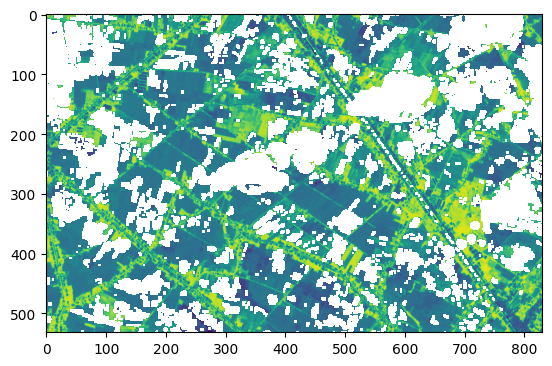

In [7]:
## ảnh ndvi chưa fill nan
plt.imshow(ndvi.isel(time=50))

In [21]:
thuanhoa_path = "ThuanHoa/region/ST_ThuanHoa_Boundaryofficially.shp"

In [14]:
# load model RF
loaded_model = joblib.load(os.path.join("model_train", "best_model.joblib"))

# dự đoán
data_array = predict(loaded_model, data_sen2.rio.crs, average_ndvi, dsvh, dsvv)

In [18]:
# cấu hình màu cho các loại đất
colors = [
    "#abcee9",
    "#ffef44",
    "#c4ff9e",
    "#ffd6a8",
    "#93ddda",
    "#1aeef7",
    "#ffa7f2",
    "#33ee33"
]
labels = [
    "Lúa tôm",
    "Lúa",
    "CHN",
    "CLN",
    "TS",
    "Sông",
    "Đất xây dựng",
    "Rừng"
]

/tmp/ipykernel_690/2294385133.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels)


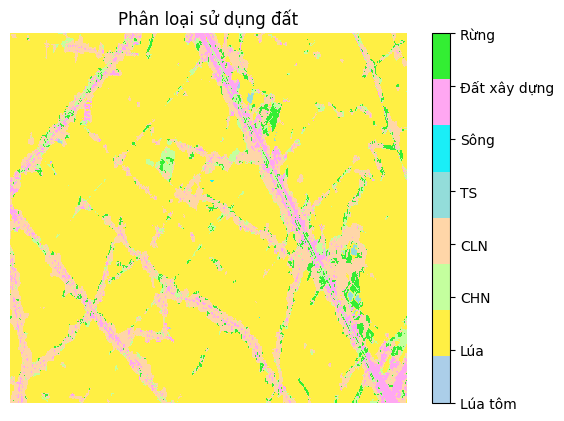

In [19]:
# hiển thị phân loại sử dụng đất
cmap = ListedColormap(colors)
img = data_array.plot(cmap=cmap, add_colorbar=False)
cbar = plt.colorbar(img)
cbar.ax.set_yticklabels(labels)
plt.title("Phân loại sử dụng đất")
plt.axis('off')
plt.show()

In [23]:
# cắt theo ranh giới xã thuận hòa
region_result = cut_according_shp(thuanhoa_path, average_ndvi, data_array)

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [24]:
# hiển thị kết quả phân loại sử dụng đất
colorval = list(range(len(colors)))
options = {
    'title': 'Phân loại sử dụng đất',
    'cmap': colors,
    'clim': (0, 8),
    'aspect': 'equal',
    'colorbar_opts': {
        'major_label_overrides': dict(zip(colorval, labels)),
        'major_label_text_align': 'left',
        'ticker': FixedTicker(ticks=colorval),
    },
}
                                      
region_result.hvplot(
    rasterize = True,                        # Use Datashader, particularly useful for dask arrays
    aggregator = reductions.mode(),          # Datashader selects mode value, requires 'hv.Image'
).options(opts.Image(**options))

:DynamicMap   []
   :Image   [x,y]   (value)

In [25]:
# Lưu lại kết quả
region_result.rio.to_raster("KetQuaPhanLoaiDat_15-09.tif")

In [18]:
# đóng client, cluster
client.close()
cluster.close()